<a href="https://colab.research.google.com/github/Qasim-Shah-73/Diabetes-Detection/blob/main/MachineLearningCoursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connecting to Drive

---



In [1]:
#Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing Libraries**

---



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# **Data Loading**

---


In [7]:
# The location of dataset is set according to the file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Applied AI/ML/Dataset'



In [8]:
# Get a list of all Excel files in the specified directory
files = [f for f in os.listdir(file_path) if f.endswith('.csv')]

In [9]:
file_path_full = os.path.join(file_path, files[0])
df = pd.read_csv(file_path_full)

In [10]:
df.head()

Time         BG         CGM  CHO   insulin      LBGI  HBGI  \
0  2023-10-25 06:00:00  86.116891   96.657960  0.0  0.022825  2.471340   0.0   
1  2023-10-25 06:05:00  86.401104   97.048611  0.0  0.022825  2.410959   0.0   
2  2023-10-25 06:10:00  86.686430   98.040064  0.0  0.022825  2.351285   0.0   
3  2023-10-25 06:15:00  86.972811   99.428400  0.0  0.022825  2.292332   0.0   
4  2023-10-25 06:20:00  87.260189  100.934520  0.0  0.022825  2.234114   0.0   

       Risk  
0  2.471340  
1  2.410959  
2  2.351285  
3  2.292332  
4  2.234114

#**Data Combing and PreProcessing**

---



In [11]:
# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Loop through each subject file and load data
for file in files:
    file_path_full = os.path.join(file_path, file)

    # Read only the relevant columns: Time, CGM, CHO, insulin
    df = pd.read_csv(file_path_full, usecols=['Time', 'CGM', 'CHO', 'insulin'])

    # Sort the data by time
    df = df.sort_values(by='Time')

    # Determine 'Subject_type' based on the file name
    if 'adolescent' in file.lower():
        df['Subject_type'] = 0
    elif 'adult' in file.lower():
        df['Subject_type'] = 1
    elif 'child' in file.lower():
        df['Subject_type'] = 2

    # Append the data to the combined DataFrame
    combined_data = combined_data.append(df, ignore_index=True)

<ipython-input-11-35712c7172e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-11-35712c7172e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-11-35712c7172e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-11-35712c7172e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-11-35712c7172e4>:23: FutureWarning: The frame.append method i

In [12]:
# Display rows of the combined dataset
print(combined_data.head(-1))

                      Time         CGM  CHO   insulin  Subject_type
0      2023-10-25 06:00:00   96.657960  0.0  0.022825             1
1      2023-10-25 06:05:00   97.048611  0.0  0.022825             1
2      2023-10-25 06:10:00   98.040064  0.0  0.022825             1
3      2023-10-25 06:15:00   99.428400  0.0  0.022825             1
4      2023-10-25 06:20:00  100.934520  0.0  0.022825             1
...                    ...         ...  ...       ...           ...
31674  2023-10-30 05:30:00  112.579457  0.0  0.006625             2
31675  2023-10-30 05:35:00  113.361990  0.0  0.006625             2
31676  2023-10-30 05:40:00  114.071279  0.0  0.006625             2
31677  2023-10-30 05:45:00  114.666332  0.0  0.006625             2
31678  2023-10-30 05:50:00  115.140354  0.0  0.006625             2

[31679 rows x 5 columns]


In [13]:
# Find missing values
missing_values = combined_data.isnull().sum()

# Display missing values
print("Missing Values:")
print(missing_values[missing_values > 0])

# Calculate correlation matrix
correlation_matrix = combined_data.corr()

# Display correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)


Missing Values:
Series([], dtype: int64)

Correlation Matrix:
                   CGM       CHO   insulin  Subject_type
CGM           1.000000 -0.033318 -0.017785     -0.201854
CHO          -0.033318  1.000000 -0.008909     -0.002618
insulin      -0.017785 -0.008909  1.000000     -0.014722
Subject_type -0.201854 -0.002618 -0.014722      1.000000


<ipython-input-13-ae38215e52d4>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = combined_data.corr()


- 1 indicates a perfect positive correlation,
- -1 indicates a perfect negative correlation,
- 0 indicates no linear correlation.

Here's the interpretation of the correlation matrix:

- CGM (Continuous Glucose Monitoring) vs. Other Variables:

  CGM has a positive correlation with CHO (Carbohydrates Intake) of approximately -0.033, indicating a very weak negative correlation. As one variable increases, the other tends to decrease slightly.
  CGM has a weak negative correlation with insulin of approximately -0.018. Again, this suggests a very weak negative relationship.

- CHO vs. Other Variables:

 CHO (Carbohydrates Intake) has a very weak negative correlation with CGM (-0.033) and a very weak negative correlation with insulin (-0.009).

- Insulin vs. Other Variables:

 Insulin has a very weak negative correlation with CGM (-0.018) and a very weak negative correlation with CHO (-0.009).

- Subject_type vs. Other Variables:

 Subject_type has a weak negative correlation with CGM (-0.202), which suggests a weak negative relationship. This may indicate that the subject type has a slight influence on CGM levels.


In [14]:
# Step 1: Visualize CGM data over time
fig_cgm = px.line(combined_data, x='Time', y='CGM', title='CGM Over Time')
fig_cgm.show()

# Step 2: Visualize CHO (Carbohydrate) intake over time
fig_cho = px.line(combined_data, x='Time', y='CHO', title='Carbohydrate Intake Over Time')
fig_cho.show()

# Step 3: Visualize Insulin administration over time
fig_insulin = px.line(combined_data, x='Time', y='insulin', title='Insulin Administration Over Time')
fig_insulin.show()


In [15]:
# Step 1: Visualize CGM data over time for each subject type
fig_cgm = px.line(combined_data, x='Time', y='CGM', color='Subject_type',
                  title='CGM Over Time for Different Subject Types',
                  labels={'CGM': 'CGM Values'},
                  color_discrete_map={0: 'blue', 1: 'orange', 2: 'green'})

fig_cgm.show()

# Step 2: Visualize CHO (Carbohydrate) intake over time for each subject type
fig_cho = px.line(combined_data, x='Time', y='CHO', color='Subject_type',
                  title='Carbohydrate Intake Over Time for Different Subject Types',
                  labels={'CHO': 'Carbohydrate Intake'},
                  color_discrete_map={0: 'blue', 1: 'orange', 2: 'green'})

fig_cho.show()

# Step 3: Visualize Insulin administration over time for each subject type
fig_insulin = px.line(combined_data, x='Time', y='insulin', color='Subject_type',
                      title='Insulin Administration Over Time for Different Subject Types',
                      labels={'insulin': 'Insulin Administration'},
                      color_discrete_map={0: 'blue', 1: 'orange', 2: 'green'})

fig_insulin.show()


In [16]:
# Step 4: Basic statistics for each feature
statistics = combined_data.describe()
print(statistics)

# Step 5: Correlation matrix to understand relationships between features
correlation_matrix = combined_data.corr()
print(correlation_matrix)

# Step 6: Pair plot for a detailed visualization of feature relationships
fig_pair = px.scatter_matrix(combined_data, dimensions=['CGM', 'CHO', 'insulin'], title='Pair Plot')
fig_pair.show()


                CGM           CHO       insulin  Subject_type
count  31680.000000  31680.000000  31680.000000  31680.000000
mean     116.387832      0.134848      0.028622      0.909091
std       52.628024      1.339566      0.150300      0.732944
min       39.000000      0.000000      0.006575      0.000000
25%       79.436662      0.000000      0.010108      0.000000
50%      107.014081      0.000000      0.014592      1.000000
75%      143.413774      0.000000      0.019667      1.000000
max      384.106087     21.400000      4.296975      2.000000
                   CGM       CHO   insulin  Subject_type
CGM           1.000000 -0.033318 -0.017785     -0.201854
CHO          -0.033318  1.000000 -0.008909     -0.002618
insulin      -0.017785 -0.008909  1.000000     -0.014722
Subject_type -0.201854 -0.002618 -0.014722      1.000000


<ipython-input-16-4ec5e6d88050>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Correlation Matrix:

- CGM vs. CHO: There is a weak negative correlation (-0.033) between CGM and CHO, suggesting a slight tendency for higher CGM values to be associated with lower carbohydrate intake.

- CGM vs. Insulin: There is a weak negative correlation (-0.018) between CGM and insulin, indicating a slight tendency for higher CGM values to be associated with lower insulin administration.

- CHO vs. Insulin: There is a very weak negative correlation (-0.009) between carbohydrate intake and insulin administration.

- Subject Type vs. Others: The subject type has a weak negative correlation with CGM, CHO, and insulin, suggesting a mild association between subject type and these features.

In [17]:
combined_data

Time         CGM  CHO   insulin  Subject_type
0      2023-10-25 06:00:00   96.657960  0.0  0.022825             1
1      2023-10-25 06:05:00   97.048611  0.0  0.022825             1
2      2023-10-25 06:10:00   98.040064  0.0  0.022825             1
3      2023-10-25 06:15:00   99.428400  0.0  0.022825             1
4      2023-10-25 06:20:00  100.934520  0.0  0.022825             1
...                    ...         ...  ...       ...           ...
31675  2023-10-30 05:35:00  113.361990  0.0  0.006625             2
31676  2023-10-30 05:40:00  114.071279  0.0  0.006625             2
31677  2023-10-30 05:45:00  114.666332  0.0  0.006625             2
31678  2023-10-30 05:50:00  115.140354  0.0  0.006625             2
31679  2023-10-30 05:55:00  115.494597  0.0  0.006625             2

[31680 rows x 5 columns]

In [18]:
#Convert the 'Time' column to a DateTime object.
combined_data['Time'] = pd.to_datetime(combined_data['Time'])

In [19]:


scaler = MinMaxScaler()
combined_data[['CGM', 'CHO', 'insulin']] = scaler.fit_transform(combined_data[['CGM', 'CHO', 'insulin']])


#**Modeling & Evaluation**

---



# 1-  LSTM




In [150]:
combined_data['Hypo_Label'] = (combined_data['CGM'].shift(-24) < 70).astype(int)
combined_data['Hyper_Label'] = (combined_data['CGM'].shift(-24) > 180).astype(int)


In [151]:
def create_sequences_with_labels(data, sequence_length):
    sequences, hypo_labels, hyper_labels = [], [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length]
        hypo_label = data['Hypo_Label'].iloc[i + sequence_length - 1]
        hyper_label = data['Hyper_Label'].iloc[i + sequence_length - 1]
        sequences.append(seq[['CGM', 'CHO', 'insulin', 'Subject_type']].values)
        hypo_labels.append(hypo_label)
        hyper_labels.append(hyper_label)
    return np.array(sequences), np.array(hypo_labels), np.array(hyper_labels)


In [153]:
# Set the number of folds
n_splits = 3

# Initialize K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize variables to store confusion matrices for each fold
confusion_matrix_hypo = np.zeros((2, 2))
confusion_matrix_hyper = np.zeros((2, 2))

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(combined_data):
    train_data, test_data = combined_data.iloc[train_index], combined_data.iloc[test_index]

    # Create sequences and labels based on the shifted CGM values
    sequence_length = 12
    X_train, y_train_hypo, y_train_hyper = create_sequences_with_labels(train_data, sequence_length)
    X_test, y_test_hypo, y_test_hyper = create_sequences_with_labels(test_data, sequence_length)

    # Build and compile the LSTM model with modified output layer names
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=2, activation='softmax', name='output_layer'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, {'output_layer': to_categorical(y_train_hypo)},  # Use 'output_layer' as the key
              epochs=10, batch_size=32, validation_data=(X_test, {'output_layer': to_categorical(y_test_hypo)}), verbose = 0)

    # Make predictions on the test set
    predictions = model.predict(X_test)
    predicted_hypo_labels = np.argmax(predictions, axis=1)
    predicted_hyper_labels = (predictions[:, 1] > 0.5).astype(int)

    # Evaluate based on binary classification metrics
    accuracy = accuracy_score(y_test_hypo, predicted_hypo_labels)
    precision = precision_score(y_test_hypo, predicted_hypo_labels)
    recall = recall_score(y_test_hypo, predicted_hypo_labels)
    f1 = f1_score(y_test_hypo, predicted_hypo_labels)

    # Update confusion matrices
    confusion_matrix_hypo += confusion_matrix(y_test_hypo, predicted_hypo_labels)
    confusion_matrix_hyper += confusion_matrix(y_test_hyper, predicted_hyper_labels)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate the mean and standard deviation of evaluation metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f'Mean Accuracy: {mean_accuracy:.4f} (Std: {std_accuracy:.4f})')
print(f'Mean Precision: {mean_precision:.4f} (Std: {std_precision:.4f})')
print(f'Mean Recall: {mean_recall:.4f} (Std: {std_recall:.4f})')
print(f'Mean F1-Score: {mean_f1:.4f} (Std: {std_f1:.4f})')

# Print confusion matrices
print("Confusion Matrix for Hypoglycemia:")
print(confusion_matrix_hypo)

print("\nConfusion Matrix for Hyperglycemia:")
print(confusion_matrix_hyper)


330/330 [==============================] - 1s 2ms/step
Mean Accuracy: 0.9993 (Std: 0.0003)
Mean Precision: 0.9993 (Std: 0.0003)
Mean Recall: 1.0000 (Std: 0.0000)
Mean F1-Score: 0.9997 (Std: 0.0002)
Confusion Matrix for Hypoglycemia:
[[0.0000e+00 2.1000e+01]
 [0.0000e+00 3.1623e+04]]

Confusion Matrix for Hyperglycemia:
[[    0. 31644.]
 [    0.     0.]]


# 2- SVM

In [20]:
# Define a function to calculate moving averages
def calculate_moving_average(data, column, time_diff, window_size):
    # Calculate the moving average
    moving_avg_col = f'{column}_{time_diff}'

    # Calculate the moving average based on the specified window size
    data[moving_avg_col] = data[column].rolling(window=window_size).mean()

    return data

# Define the time differences and window sizes
time_diffs = [1, 2]  # 1 hour and 2 hours
window_size = 12  # 12 data points for 1 hour

# Apply moving averages for CGM, Insulin, and CHO columns
columns_to_process = ['CGM', 'insulin', 'CHO']
for column in columns_to_process:
    for time_diff in time_diffs:
        # Calculate moving averages for data before the current time
        combined_data = calculate_moving_average(combined_data, column, f'{time_diff}B', window_size)

        # Calculate moving averages for data after the current time
        combined_data = calculate_moving_average(combined_data, column, f'{time_diff}A', window_size)

# Display the resulting DataFrame
print(combined_data)

                     Time       CGM  CHO   insulin  Subject_type    CGM_1B  \
0     2023-10-25 06:00:00  0.167073  0.0  0.003788             1       NaN   
1     2023-10-25 06:05:00  0.168205  0.0  0.003788             1       NaN   
2     2023-10-25 06:10:00  0.171078  0.0  0.003788             1       NaN   
3     2023-10-25 06:15:00  0.175101  0.0  0.003788             1       NaN   
4     2023-10-25 06:20:00  0.179465  0.0  0.003788             1       NaN   
...                   ...       ...  ...       ...           ...       ...   
31675 2023-10-30 05:35:00  0.215476  0.0  0.000012             2  0.203762   
31676 2023-10-30 05:40:00  0.217531  0.0  0.000012             2  0.206242   
31677 2023-10-30 05:45:00  0.219255  0.0  0.000012             2  0.208434   
31678 2023-10-30 05:50:00  0.220629  0.0  0.000012             2  0.210382   
31679 2023-10-30 05:55:00  0.221655  0.0  0.000012             2  0.212158   

         CGM_1A    CGM_2B    CGM_2A  insulin_1B  insulin_1A  in

In [21]:
# Create a new column 'Event_Label' with default value 0 (normal)
combined_data['output'] = 0

# Identify hypo events (CGM < 70) and set 'Event_Label' to 1
combined_data.loc[combined_data['CGM_2A'].shift(-24) < 70, 'output'] = 1

# Identify hyper events (CGM > 180) and set 'Event_Label' to 2
combined_data.loc[combined_data['CGM_2A'].shift(-24) > 180, 'output'] = 2

In [22]:
combined_data = combined_data.fillna(method='ffill')  # Forward fill
combined_data = combined_data.fillna(combined_data.mean())
print(combined_data)

                     Time       CGM  CHO   insulin  Subject_type    CGM_1B  \
0     2023-10-25 06:00:00  0.167073  0.0  0.003788             1  0.224253   
1     2023-10-25 06:05:00  0.168205  0.0  0.003788             1  0.224253   
2     2023-10-25 06:10:00  0.171078  0.0  0.003788             1  0.224253   
3     2023-10-25 06:15:00  0.175101  0.0  0.003788             1  0.224253   
4     2023-10-25 06:20:00  0.179465  0.0  0.003788             1  0.224253   
...                   ...       ...  ...       ...           ...       ...   
31675 2023-10-30 05:35:00  0.215476  0.0  0.000012             2  0.203762   
31676 2023-10-30 05:40:00  0.217531  0.0  0.000012             2  0.206242   
31677 2023-10-30 05:45:00  0.219255  0.0  0.000012             2  0.208434   
31678 2023-10-30 05:50:00  0.220629  0.0  0.000012             2  0.210382   
31679 2023-10-30 05:55:00  0.221655  0.0  0.000012             2  0.212158   

         CGM_1A    CGM_2B    CGM_2A  insulin_1B  insulin_1A  in

<ipython-input-22-d59408bad40f>:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [23]:
# Drop 'CGM_2A' and 'Time' columns
combined_data = combined_data.drop(['CGM_2A', 'Time'], axis=1)

# Separate features (X) and target variable (y)
X = combined_data.drop('output', axis=1)  # Assuming 'output' is the target variable
y = combined_data['output']

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Set the number of folds
n_splits = 5

# Initialize K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize variables to store confusion matrices for each fold
confusion_matrix_hypo = np.zeros((2, 2))
confusion_matrix_hyper = np.zeros((3, 3))

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X_normalized):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the SVM model
    svm_model = SVC(kernel='linear', C=1.0)
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    svm_predictions = svm_model.predict(X_test)

    # Update confusion matrices for both hypo and hyper
    confusion_matrix_hypo += confusion_matrix(y_test, svm_predictions, labels=[1, 0])
    confusion_matrix_hyper += confusion_matrix(y_test, svm_predictions, labels=[2, 0, 1])

    # Evaluate the SVM model
    accuracy = accuracy_score(y_test, svm_predictions)
    precision = precision_score(y_test, svm_predictions, average='weighted')
    recall = recall_score(y_test, svm_predictions, average='weighted')
    f1 = f1_score(y_test, svm_predictions, average='weighted')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate the mean and standard deviation of evaluation metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f'Mean Accuracy: {mean_accuracy:.4f} (Std: {std_accuracy:.4f})')
print(f'Mean Precision: {mean_precision:.4f} (Std: {std_precision:.4f})')
print(f'Mean Recall: {mean_recall:.4f} (Std: {std_recall:.4f})')
print(f'Mean F1-Score: {mean_f1:.4f} (Std: {std_f1:.4f})')

# Print confusion matrices
print("Confusion Matrix for Hypoglycemia:")
print(confusion_matrix_hypo)

# Print confusion matrices for hyperglycemia
print("\nConfusion Matrix for Hyperglycemia:")
print(confusion_matrix_hyper)


Mean Accuracy: 0.9992 (Std: 0.0003)
Mean Precision: 0.9985 (Std: 0.0006)
Mean Recall: 0.9992 (Std: 0.0003)
Mean F1-Score: 0.9989 (Std: 0.0005)
Confusion Matrix for Hypoglycemia:
[[3.1656e+04 0.0000e+00]
 [2.4000e+01 0.0000e+00]]

Confusion Matrix for Hyperglycemia:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 2.4000e+01]
 [0.0000e+00 0.0000e+00 3.1656e+04]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p

<ipython-input-24-6b5d2ebfcdb5>:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


<ipython-input-24-6b5d2ebfcdb5>:8: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


<ipython-input-24-6b5d2ebfcdb5>:12: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




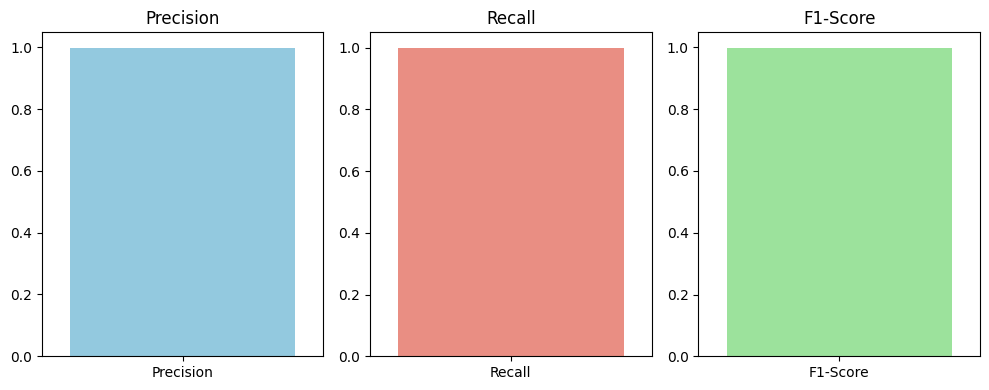

In [24]:
# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.barplot(x=['Precision'], y=[mean_precision], ci='sd', color='skyblue')
plt.title('Precision')

plt.subplot(1, 3, 2)
sns.barplot(x=['Recall'], y=[mean_recall], ci='sd', color='salmon')
plt.title('Recall')

plt.subplot(1, 3, 3)
sns.barplot(x=['F1-Score'], y=[mean_f1], ci='sd', color='lightgreen')
plt.title('F1-Score')

plt.tight_layout()
plt.show()

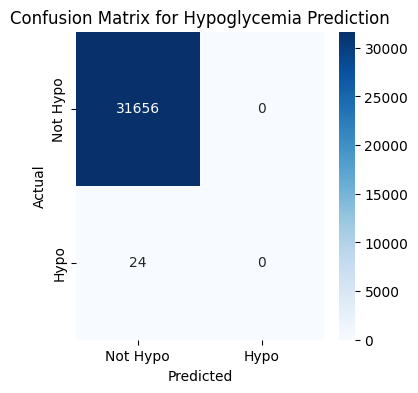

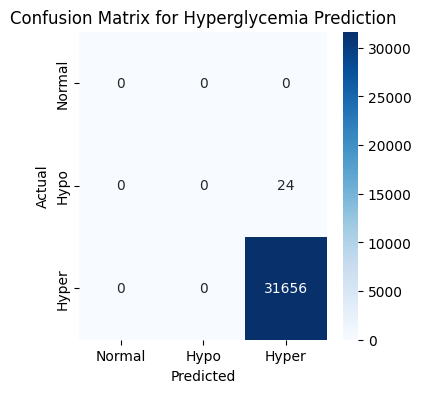

In [25]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix_hypo, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Hypo', 'Hypo'], yticklabels=['Not Hypo', 'Hypo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hypoglycemia Prediction')
plt.show()

# Plot confusion matrix for hyperglycemia
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix_hyper, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Hypo', 'Hyper'], yticklabels=['Normal', 'Hypo', 'Hyper'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hyperglycemia Prediction')
plt.show()

In [26]:
import plotly.graph_objects as go

# Define function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, title):
    fig = go.Figure()

    fig.add_trace(go.Heatmap(z=conf_matrix,
                             x=class_names,
                             y=class_names,
                             colorscale='Viridis'))

    fig.update_layout(title=title,
                      xaxis_title='Predicted',
                      yaxis_title='True',
                      template='plotly_white')

    return fig

# Class names for confusion matrices
class_names_hypo = ['Normal', 'Hypo']
class_names_hyper = ['Normal', 'Hypo', 'Hyper']

# Plot confusion matrix for hypoglycemia
fig_hypo = plot_confusion_matrix(confusion_matrix_hypo, class_names_hypo, 'Confusion Matrix for Hypoglycemia')
fig_hypo.show()

# Plot confusion matrix for hyperglycemia
fig_hyper = plot_confusion_matrix(confusion_matrix_hyper, class_names_hyper, 'Confusion Matrix for Hyperglycemia')
fig_hyper.show()
